In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gpxpy.gpx

In [2]:
%matplotlib inline

In [3]:
sns.set()

In [31]:
name = 'giacomo'
date = datetime(2019,3,18)
filename = '{}_{}.pkl'.format(name,date.strftime('%d%b%y'))
filename

'giacomo_17Mar19.pkl'

In [32]:
data = pd.read_pickle('processed_data/'+filename)


In [33]:
data.reset_index(drop=True,inplace=True)

In [34]:
data.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt,Lat_Rad,Lon_Rad,Lat_Delta,Lon_Delta,Lat_Rad_Delta,Lon_Rad_Delta,GPS_Alt_Delta,distance,gradient,grad_colour
0,03/17/2019,08:10:25,45.090736,6.063516,1789.4,81897.336,1759.858,21.29,4.325,0.786982,0.105828,5.000000e-07,0.000001,8.726646e-09,2.321288e-08,NaN,0.118325,NaN,2
1,03/17/2019,08:10:28,45.090736,6.063514,1789.7,81895.141,1760.075,21.29,4.325,0.786982,0.105828,-6.000000e-06,-0.000004,-1.047198e-07,-7.557276e-08,0.3,0.749005,68.172355,0
2,03/17/2019,08:10:29,45.090742,6.063518,1790.1,81893.922,1760.196,21.31,4.325,0.786982,0.105828,-1.200000e-05,0.000001,-2.094395e-07,2.617994e-08,0.4,1.339945,73.378602,0
3,03/17/2019,08:10:30,45.090754,6.063517,1789.4,81894.516,1760.137,21.31,4.318,0.786982,0.105828,-5.330000e-06,0.000004,-9.302605e-08,6.108652e-08,-0.7,0.653465,-43.030807,2
4,03/17/2019,08:10:31,45.090759,6.063514,1789.2,81899.484,1759.645,21.33,4.325,0.786982,0.105828,-4.170000e-06,0.000001,-7.278023e-08,2.617994e-08,-0.2,0.478551,-67.318580,2


In [35]:
data['gps_alt_roll']=data.GPS_Alt.rolling(400).mean()

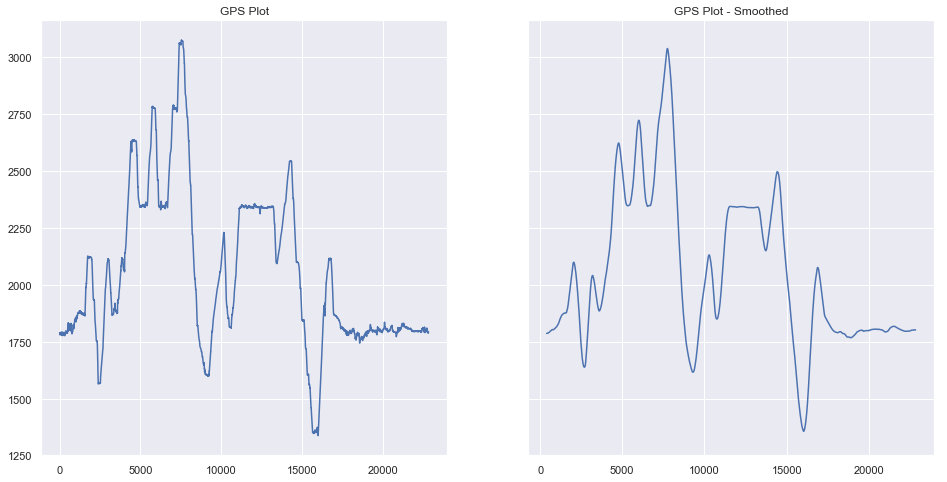

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.GPS_Alt.plot(ax=ax1,title='GPS Plot')
data.gps_alt_roll.plot(ax=ax2,title='GPS Plot - Smoothed')


In [37]:
data['gps_alt_roll_delta'] = data.gps_alt_roll[:-1] - data.gps_alt_roll[1:].values
data['gps_alt_raw_delta'] = data.GPS_Alt[:-1] - data.GPS_Alt[1:].values

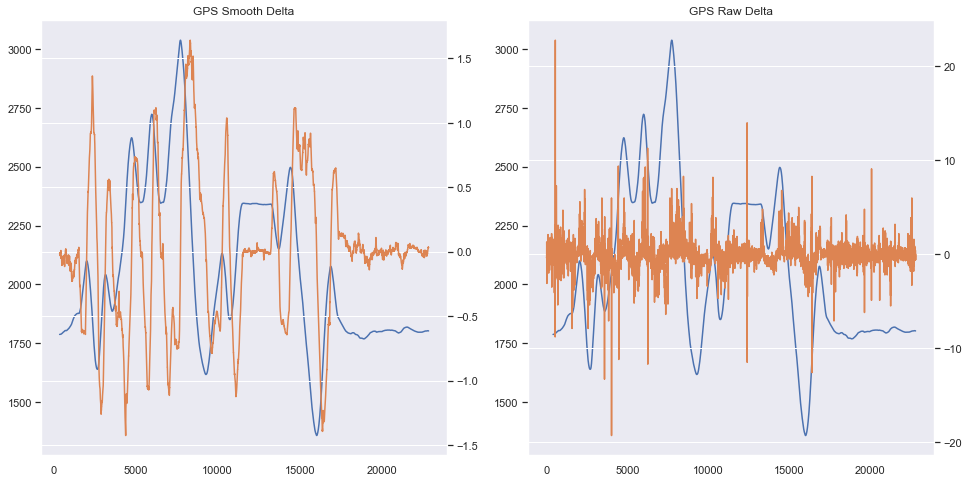

In [38]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta')
data.gps_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta')
data.gps_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

In [39]:
#data['gps_alt_roll_delta_roll_delta'] = data.gps_alt_roll_delta_roll[:-1] - data.gps_alt_roll_delta_roll[1:].values
#data['gps_alt_roll_delta_roll_delta_roll'] =data.gps_alt_roll_delta_roll_delta.rolling(240).mean()

#data['gps_alt_raw_delta_roll_delta'] = data.gps_alt_raw_delta_roll[:-1] - data.gps_alt_raw_delta_roll[1:].values
#data['gps_alt_raw_delta_roll_delta_roll'] =data.gps_alt_raw_delta_roll_delta.rolling(240).mean()

data['gps_alt_raw_delta_roll'] =data.gps_alt_raw_delta.rolling(180).mean()
data['gps_alt_roll_delta_roll'] =data.gps_alt_roll_delta.rolling(180).mean()

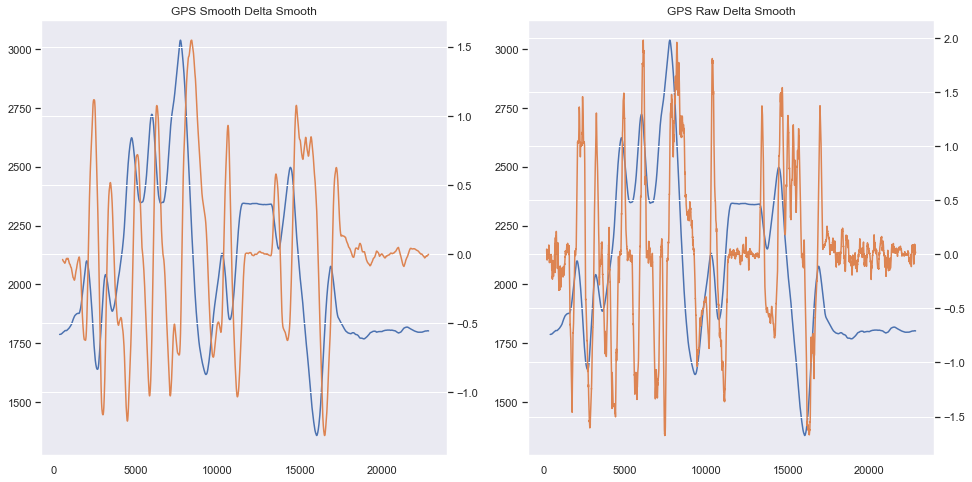

In [40]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta Smooth')
data.gps_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta Smooth')
data.gps_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

In [41]:
signs = np.sign(data.gps_alt_raw_delta_roll.fillna(0))
signchange = ((np.roll(signs, 1) - signs) != 0).astype(int)

In [42]:
sign_changes_idx = signchange.index[signchange == 1].tolist()

In [43]:
routes_list=[]
for i in range(len(sign_changes_idx)-1):
    #print(sign_changes_idx[i],sign_changes_idx[i+1]-1, signs[sign_changes_idx[i]])
    start = sign_changes_idx[i]
    end = sign_changes_idx[i+1]-1
    sign = signs[sign_changes_idx[i]]
    max_val = np.max(data.loc[start:end,('gps_alt_raw_delta_roll')])
    routes_list.append((start,end,sign,max_val ))
    
routes = pd.DataFrame(routes_list,columns=['start_idx','end_idx','sign','peak'])
routes.head()

,start_idx,end_idx,sign,peak
0,179,185,1.0,0.047222
1,186,227,-1.0,-0.001111
2,228,263,1.0,0.044444
3,264,298,-1.0,-0.000556
4,299,304,1.0,0.013333


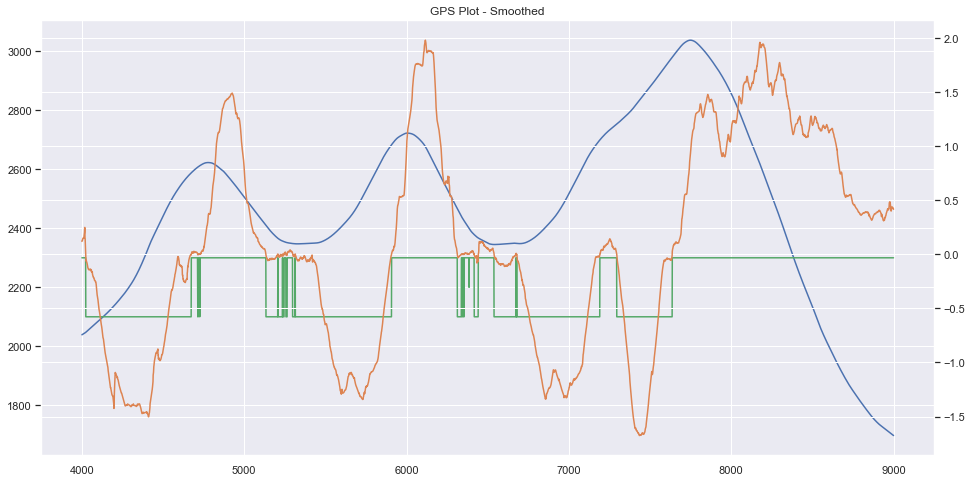

In [44]:
small_data =data.loc[4000:9000]
small_signs = signs.loc[4000:9000] *100 +2200
fig, ax= plt.subplots(1, 1, figsize=(16,8))
small_data.gps_alt_roll.plot(ax=ax,title='GPS Plot - Smoothed')
small_data.gps_alt_raw_delta_roll.plot(ax=ax,secondary_y=True)
small_signs.plot(ax=ax)

In [45]:
peak_filter = 0.5
runs = routes[(routes.sign== 1) & (routes.peak >= peak_filter)].copy()
runs.reset_index(inplace=True)
num_runs = runs.shape[0]
num_runs

9

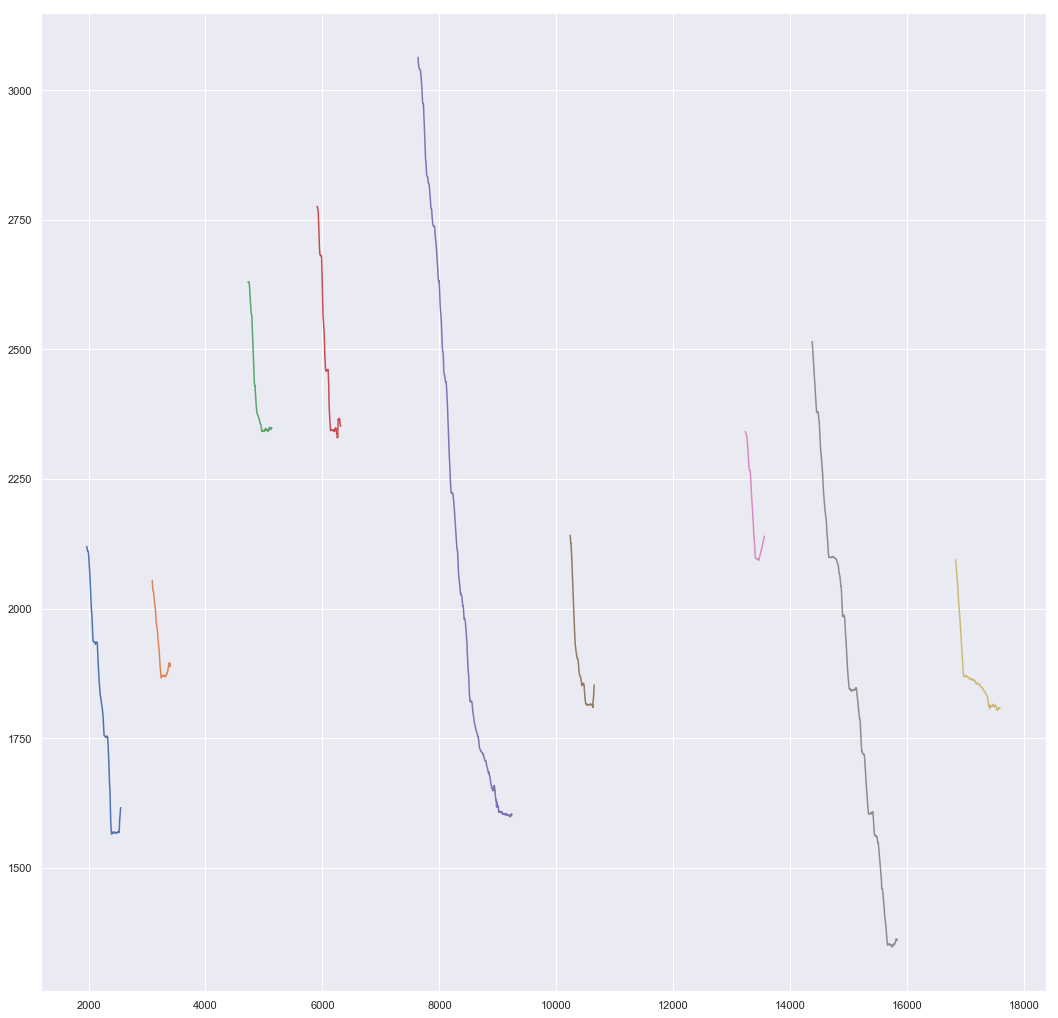

In [46]:
fig, axes= plt.subplots(1,1, figsize=(18,18))
#axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes)

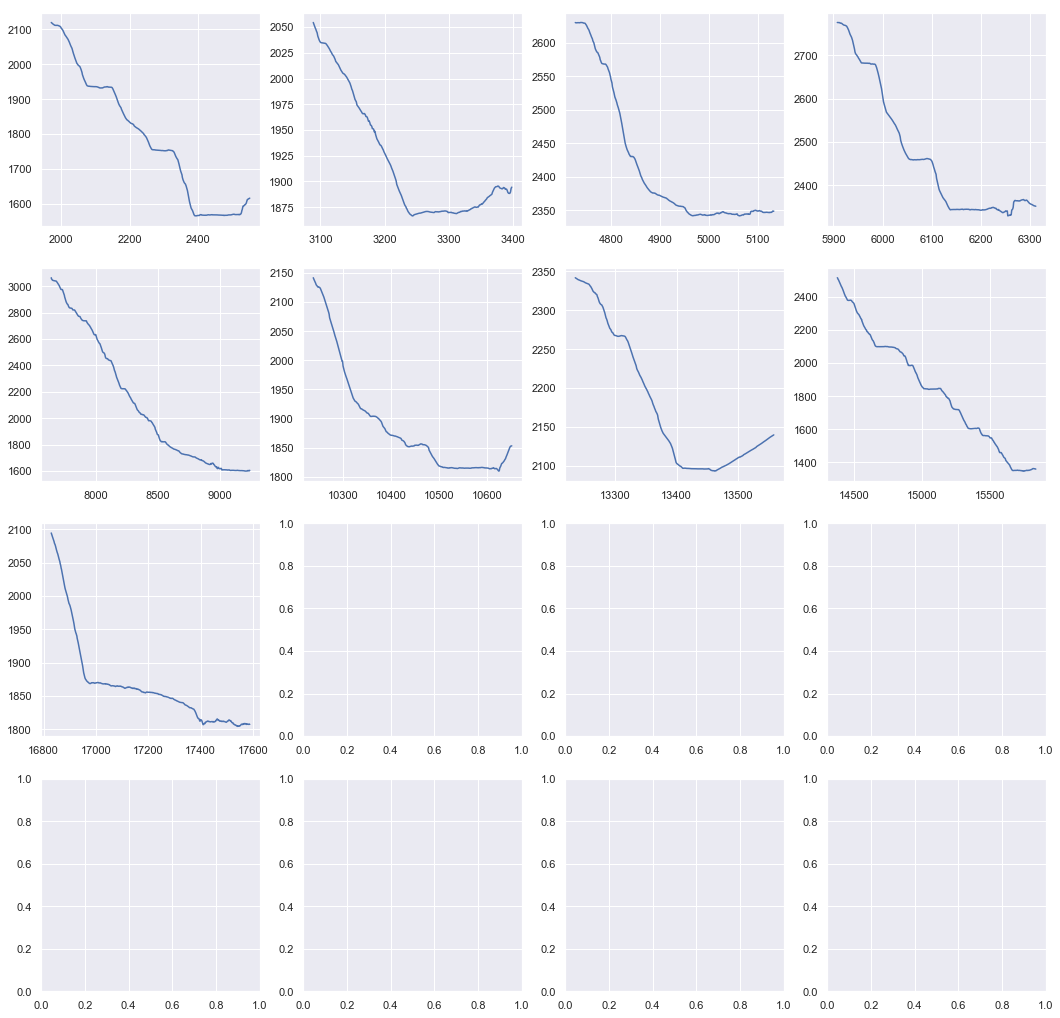

In [47]:
fig, axes= plt.subplots(4, 4, figsize=(18,18))
axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes[i])

In [50]:
save_gpx_run(data,runs,name, date)

0
1
2
3
4
5
6
7
8
giacomo_17Mar19_runs.xml


In [53]:
save_json_run(data,runs,name, date)

0
giacomo_17Mar19_0.json
1
giacomo_17Mar19_1.json
2
giacomo_17Mar19_2.json
3
giacomo_17Mar19_3.json
4
giacomo_17Mar19_4.json
5
giacomo_17Mar19_5.json
6
giacomo_17Mar19_6.json
7
giacomo_17Mar19_7.json
8
giacomo_17Mar19_8.json
